# COVID-19
#### Fitting a RNN network onto country with similar growth

The aim of this notebook is to provide a solution for predicting the feature spread of the COVID-19 pandemic using Reccurent Neural Networks. Besides this, it is inteded to be educational and to explaing some basic concepts of working and using a RNN in the context of multi-time series prediction.

## Introduction

Training a single model for all countries can raise a multitude of problems one of them being data scaling. Neural networks need data represented in a small interval, usually in the range \[-1, 1\]. The samples that we are working with consist of the number of confirmed cases and fatalities, each of it being grouped by country. These entries have a very high standard deviation and trying to normalize this data by applying a single scale factor over the whole dataset will lead to into a big preccision loss and would not help at all. We address this problem by diving the training for each individual country and only consider its nearest neighbours inn terms of COVID-19 spread growth. 

## Imports

Set-up environment

In [1]:
import os
import warnings 
warnings.filterwarnings('ignore')
os.chdir('..')

Importing external packages.

In [2]:
import time
import torch
import statistics

import numpy   as np 
import pandas  as pd

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.metrics       import mean_squared_log_error
from sklearn.preprocessing import StandardScaler

from tqdm             import tqdm
from IPython.display  import display 

from torch import nn
from torch import optim
from torch.optim import lr_scheduler

Import local packages

In [3]:
from core.data      import compare_countries as cc
from core.data      import utils             as dataUtils

from core.nn        import WeightInitializer
from core.nn.loss   import l1_norm_error
from core.nn.loss   import GradientSmoothLoss

from core.networks  import BasicRecurrentPredictor

In [4]:
# set values for reproduceble results
torch.manual_seed(123);
torch.cuda.manual_seed(123)
np.random.seed(123)
torch.backends.cudnn.deterministic = True

### Globals

In [5]:
COUNTRY      = 'Italy'
DEVICE       = 'cpu'
TRAIN_UP_TO  = pd.to_datetime('2020-04-25')

## Data

The initial data which this notebook used is the one from [Kaggle's COVID-19 spread prediciton](https://www.kaggle.com/c/covid19-global-forecasting-week-4) competition. It consists of countries and their states (where needed) and the number of confirmed cases and fatalities per day. Because this source will no longer be updated, the data will be collected from this [GitHub](https://github.com/CSSEGISandData/COVID-19) repository  created by Johns Hopkins CSSE. Also the sources ```.csv``` have different formats(columns), I have chosen to work with the original format.

Inorder to use this notebook with the latest data, please run the script ```scripts/convert_data_format.py ```. This will download the data direct from the repo and convert it to the appropiate format.

### Loading the data

In [6]:
allData = pd.read_csv('assets/covid_spread.csv', parse_dates=['Date'])
allData.head()

,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,NaN,Afghanistan,2020-01-22,0.0,0.0
1,NaN,Afghanistan,2020-01-23,0.0,0.0
2,NaN,Afghanistan,2020-01-24,0.0,0.0
3,NaN,Afghanistan,2020-01-25,0.0,0.0
4,NaN,Afghanistan,2020-01-26,0.0,0.0


To make the data easier to use, I will work "Province_State" based. The preprocessing step will replace the Province_state with the name of the country (if it has no state).

In [7]:
allData = dataUtils.preprocess_data(allData)
allData.head()

,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,Afghanistan,Afghanistan,2020-01-22,0.0,0.0
1,Afghanistan,Afghanistan,2020-01-23,0.0,0.0
2,Afghanistan,Afghanistan,2020-01-24,0.0,0.0
3,Afghanistan,Afghanistan,2020-01-25,0.0,0.0
4,Afghanistan,Afghanistan,2020-01-26,0.0,0.0


### Computing the errors

In the previous notebook I have explained how getting the nearest neighbour work. But as a short revision, only take the countries which are more "advanced" in the pandemic that the source country, select the data using a threshold(for confirmed and fatalities discard everything that is smaller than this) and to search for the smallest error by slidding the source over the target and computing it at every step. The final error is represented by the smalles error, also it is stored the index from which that happened.  

The result is a dataframe containing the following:
- **Province_State** : the name of the state/province
- **deathError**     : the minimum error that was found between source and that specific country for fatalities
- **deathIdx**       : the index where the above error was found (in the thresholded array)
- **confirmedError** : the minimum error that was found between source and that specific country for confirmed cases
- **confirmedIdx**   : the index where the above error was found (in the thresholded array)

When comparing, I choose to use **MAPE** (mean absolute percenta error). This will give us the error in percentage relative to the source country, hence being easier to interpret and understand.  


In [8]:
errorData  = cc.get_nearest_sequence(allData, COUNTRY, 
                                     alignThreshConf = 500,
                                     alignThreshDead = 20,  
                                     errorFunc       = l1_norm_error
                                    )

display(errorData.sort_values(by='confirmedError').head())
display(errorData.sort_values(by='deathError').head())

,Province_State,deathError,confirmedError,deathIdx,confirmedIdx
0,Hubei,0.678736,0.49097,0,0


,Province_State,deathError,confirmedError,deathIdx,confirmedIdx
0,Hubei,0.678736,0.49097,0,0


### Creating traning data

We select the for training only the countries that have an average error smaller that a threshold. I do this for both confirmed cases and fatalities and this is due to the fact that there are goinf to be trained one RNN model for each attribute. This will be further splitted andtransformed into bacthes splitted into test and validation data.

In [9]:
confData = dataUtils.get_target_data(allData, errorData, 
                                     errorThresh = .5, 
                                     country     = COUNTRY, 
                                     target      = 'confirmed')
deadData = dataUtils.get_target_data(allData, errorData, 
                                     errorThresh = .5, 
                                     country     = COUNTRY, 
                                     target      = 'fatalities')

confData.head()

,Date,Province_State,ConfirmedCases
7350,2020-01-22,Hubei,444.0
7351,2020-01-23,Hubei,444.0
7352,2020-01-24,Hubei,549.0
7353,2020-01-25,Hubei,761.0
7354,2020-01-26,Hubei,1058.0


One important aspect is scaling the date. I will use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) because a small standard deviation is expected for features. This scaler will be further used for scaling both the training data and the model predictions.

In [10]:
confScaler = dataUtils.get_scaler(confData, 'confirmed')
deadScaler = dataUtils.get_scaler(deadData, 'fatalities')

## Predicting

### Model

The reccurent predictor is composed from 2 parts:
- reccurent cells  
- multi layer perceptron that is applied after each encoded timpestamp 
Each part will be individually configured. For a detailed view, you can consult [networks](core/networks) package.

We are going to train 2 individual models for each feature, Confirmed Cases and Fatalities. The reason for this _split_ is the fact the data is not of equal length and this would be a little bit of an overhead for solving in this notebook. 

In the following section, I will explain and motivate the configuration and personal choices that I have made: 

![RNN_Flow](../assets/images/rnn_model.png)

#### Parameters

These define overall shapes of the data and the size of the embeddings:
- **chNo**   : the number of input and output features, they must have the same length, in out case this       
- **future** : the number of timestapms to predict into the feature 

#### RNN parameters

- **rnnCell** : RNN cell types that are supported in Pytorch (LSTM/GRU/RNN), the most powerfull one is LSTM, though, having a small amount of data(like in our case) GRU may be better choice thus is generalize better. RNNCell is also an option yet, but it yielded the worst results
- **rnnNoCells** : represent the number of reccurent cells in the model a higher number leads to a very unstable model (especially for this task) and the exploding gradients problem occurs very often during training 
- **hidChNo** : number of RNN cell hidden dimension

**Note**: yes, this part could have been implemented using the higher level and more optimized [API](https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM) from PyTorch, but I think this is more expressive and easier to understand and it is not such does not require a lot more code

#### MLP parameters

- **mlpLayerCfg** : a list with the numbers of neurons in each hidden layer. The layers might be wideer but is to be avoided having a very deep network (numerical instability during training and no real benefit from it)
- **mlpActiv** : activation layer after each dense/linear layer, I have used [PReLU](https://pytorch.org/docs/stable/nn.html#prelu) which is a sort of learnable loss 
- **dropRate** : dropout rate applied after each dense/linear layer, for our case 0 is used
- **normType** : normalization layer, not used used
- **mlpActivLast** : last layer activation function 

## Training

Because the both Confirmed and Fatalities are going to follow the same lead and only a few parameters will vary, I will only explain once everything and add a few notes if that will be necessarly. 

In [11]:
w = WeightInitializer()

### Confirmed

For this section we have more data, since the cases have started earlier and the fatalities came later on. 

#### Model

Let's initialize the model:

In [12]:
# build the model
confModel = BasicRecurrentPredictor(
            # parameters
            chNo        = 1,          # number of input features
            future      = 0,
            returnFullSeq = True,     # return both the encoded sequence 
                                      # and the future prediction
    
            # RNN
            rnnCell     = 'LSTMCell', # RNN cell type (LSTM/GRU/RNN)
            rnnNoCells  = 1,          # no of RNN cells
            hidChNo     = 16,         # number of RNN cell hidden dimension
            
            # MLP
            mlpLayerCfg   = [4],      # layer hidden dims
            mlpActiv      = 'PReLU',  # inner activation of the mlp
            dropRate      = None,     # dropout rate for each layer of mlp
            normType      = None,     # normalization type
            mlpActivLast  = None      # note that every timestamp 
                                      # in the sequence will be activated too
            
            ).build()

Moving on, the model will have the weights initialized as as follows:
- RNN : default (provided by PyTorch)
- MLP : normal distribution

In [13]:
w.init_weights(confModel, 'normal_', {})

#### Timming constants

![data_model](../assets/images/data_diagram.png)

Now we need to define timming constants: 
- **winSize**     - the  size of observation period and prediction period 
- **obsSize**     - number of timestemps used for observation
- **futureSteps** - the number of predicted days, not including the observation perioud
- **supPredSteps** - are the number predicted days that are going to be optimized in a supervised manner
- **uPredSteps** - are the number predicted days that are going to be optimized in an unsupervised manner
- **allPredSteps** - the total length of the prediction output including the observation period and the future steps

Please check the above scheme for a better understanding.

In [14]:
winSize       = 10
obsSize       = 5
futureSteps   = 15
supPredSteps  = winSize - obsSize
uPredSteps    = futureSteps - supPredSteps
allPredSteps  = futureSteps + obsSize

#### Train Data

Split the dataframe from the previously selected data into batches and normalize it. The data is only select until a specific date, and the rest is left for validation.  

In [15]:
confTrainData = dataUtils.get_train_data(confData, 'confirmed', 
                                  step       = 1,
                                  winSize    = winSize, 
                                  trainLimit = TRAIN_UP_TO, 
                                  scaler     = confScaler,
                                  shuffle    = True)
confTrainData.shape

torch.Size([161, 10, 1])

#### Loss

$$ \mathcal{L}_{total} = \mathcal{L}_{sup} + \mathcal{L}_{unsup} $$

##### Supervised loss

As training loss we use [SmoothL1Loss](https://pytorch.org/docs/stable/nn.html#torch.nn.SmoothL1Loss)(Huber Loss), it is less sensitive to outliers than MSELoss and prevents exploding gradients.

In [16]:
confLoss  = nn.SmoothL1Loss()

##### Unsupervised loss

It may not be very straight forward from data that the output should somehow resemble a logistic curve, so do this we are trying to optimize this in an unsupervised manner. A smoothing loss, is implied which will limit the growth of a function over a large periods. 

To better scale this loss and to make it more stable, insead of scaling the final result I chose clipping the values before averaging them. 

Please note that the the length of the prediciton and the clipping values are considered hyperparameters, and they should be tuned for each country.

In [17]:
gradsTrain  = confTrainData[:, 1:] - confTrainData[:, :-1] 
confGradMax = gradsTrain.max()

confGLoss   = GradientSmoothLoss(confGradMax, uPredSteps)

#### Optimizer

As optimization algorithm the LBFGS one is chosed, it is a very memory expensive algorithm, but since we have such little data, it works just fine. For more details about how it works I leave the following link on [Quora](https://www.quora.com/Is-the-L-bfgs-always-better-than-stochastic-gradient-descent?share=1).

In [18]:
confOptim = optim.LBFGS(confModel.parameters(), 
                        lr             = 0.05, 
                        max_iter       = 75, 
                        tolerance_grad = 1e-7, 
                        history_size   = 75)

#### Device 

Now let's move everything on the same device.

In [19]:
confModel.to(DEVICE);
confTrainData = confTrainData.to(DEVICE);

#### Closure

The closure is the function that is passed to the optimizers. Here is the "bussines logic" of the training process. For the first OBS_SIZE steps, the models prediction is based on the input data, from there, it uses it's own prediction. The whole sequence is returned and evaluted for optimization. 

For better stability, after the loss is computed, the gradients are clipped such that their L2 norm is 1. For more details check this [article](https://machinelearningmastery.com/exploding-gradients-in-neural-networks/) by Jason Brownlee.

![image.png](../assets/images/model_data.png)

In [20]:
def conf_closure():
    confOptim.zero_grad()
    confModel.returnFullSeq = True
    
    # slice data
    obsData = confTrainData[:,:obsSize]
    
    # make prediction
    out  = confModel(obsData, future = futureSteps)
    out  = out.reshape(-1, allPredSteps, 1)
    
    # compute gradients
    loss = confLoss(out[:, :winSize], confTrainData)
    
    # unsupervised loss
    smoothLoss = confGLoss(out[:,winSize:], 0.25)
    loss += smoothLoss 
    
    # make prediciton follow an ascending trend
    # by forcing the gradients to be positie (still testing)
    grads = out[:, 1:] - out[:, :-1]
    grads[grads > 0] = 0
    grads = grads.mean().abs()
    loss += grads
    loss.backward()
    
    # clip gradients / numerical stability
    nn.utils.clip_grad_norm_(confModel.parameters(), 1.0)
      
    return loss

#### Train loop

Training loop is the section where the parameters are optimized.

In [21]:
pBar = tqdm(range(10))
for i in pBar:
    loss = confOptim.step(conf_closure)
    
    # update tqdm to show loss and lr
    pBar.set_postfix({'Loss ' : loss.item(), 
                      'Lr'    : confOptim.param_groups[0]['lr']})
    
    if torch.isnan(loss):
        raise ValueError('Loss is NaN')

100%|██████████████████████████████████| 10/10 [02:10<00:00, 13.08s/it, Loss =0.000737, Lr=0.05]


### Evaluate

The evaluation process is done for the source country only. For this, the last OBS_SIZE timestemps from the train data are fed into the model, and the output is compared with data from validation period. 

In [22]:
confValData, confValLabel = dataUtils.get_val_data(confData, 'confirmed', 
                                                   COUNTRY, 
                                                   TRAIN_UP_TO, 
                                                   obsSize, 
                                                   confScaler)
confValData = confValData.to(DEVICE)

For evaluating the prediction, MAPE is used. The error is only computed on the predicted future and not on the predicted observation period. 

MAPE : 0.03836  (not normalized)


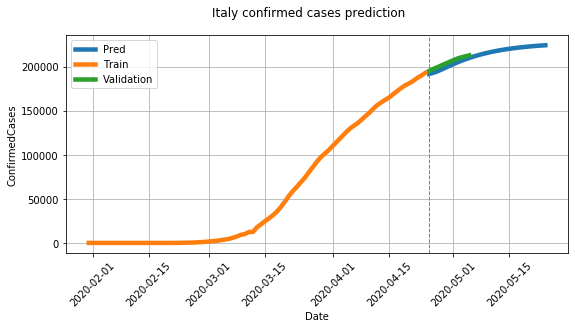

In [23]:
confModel.eval()
# get figure
fig, ax = plt.subplots(1, 1, figsize = (9, 4))
ax.tick_params(axis='x', rotation=45)
fig.suptitle(COUNTRY + ' confirmed cases prediction')

# make prediction
confModel.returnFullSeq = False
pred   = confModel(confValData, future = 30).cpu().detach().numpy()
pred   = confScaler.inverse_transform(pred[0])

error  = l1_norm_error(pred[:confValLabel.shape[0]], confValLabel.numpy())
print("MAPE : %2.5f"% error.item(), ' (not normalized)')             

# prediction
predDate = pd.date_range(start = TRAIN_UP_TO, periods=pred.shape[0])              
sns.lineplot(y = pred, x = predDate, ax = ax, linewidth=4.5)

# plot train data
showTrainData = confData[confData['Province_State'] == COUNTRY]
showTrainData = showTrainData[showTrainData['Date'] < TRAIN_UP_TO]
sns.lineplot(y = 'ConfirmedCases', x = 'Date', data = showTrainData, ax = ax, linewidth=4.5)

# plot val data
showValData = confData[confData['Province_State'] == COUNTRY]
showValData = showValData[showValData['Date'] >= TRAIN_UP_TO]
sns.lineplot(y = 'ConfirmedCases', x ='Date', data = showValData, ax = ax, linewidth=4.5);

ax.legend(['Pred', 'Train', 'Validation'])
ax.axvline(x=TRAIN_UP_TO, ymin = 0.0, ymax = 1.0, linestyle='--', lw = 1, color = '#808080')
ax.grid(True)

### Fatalities

Because all the explication were done in the previous section, here cleaner view of the code is provided.

#### Model

Initialize the model

In [24]:
# build the model
deadModel = BasicRecurrentPredictor(
            # basic parameters
            chNo          = 1,              # number of input features
            future        = 0,
            returnFullSeq = True,
    
            # RNN
            rnnCell       = 'LSTMCell',     # RNN cell type (LSTM/GRU/RNN)
            rnnNoCells    = 1,              # no of RNN cells
            hidChNo       = 16,             # number of RNN cell hidden dimension
    
            # MLP
            mlpLayerCfg   = [4],            # layer hidden dims
            mlpActiv      = 'PReLU',        # inner activation of the mlp
            dropRate      = None,           # dropout rate for each layer of mlp
            normType      = None,           # normalization type
            mlpActivLast  = None,           # note that every timestamp in the sequence 
                                            # will be activated too
            ).build()

Initialize models weights.

In [25]:
w.init_weights(deadModel, 'normal_', {})

#### Timming constants

In [26]:
winSize       = 10
obsSize       = 5
futureSteps   = 12
supPredSteps  = winSize - obsSize
uPredSteps    = futureSteps - supPredSteps
allPredSteps  = futureSteps + obsSize

#### Train data

In [27]:
deadTrainData = dataUtils.get_train_data(deadData, 'fatalities', 
                                      step       = 1,
                                      winSize    = winSize, 
                                      trainLimit = TRAIN_UP_TO, 
                                      scaler     = deadScaler,
                                      shuffle    = True)
deadTrainData.shape

torch.Size([55, 10, 1])

#### Loss

In [28]:
deadLoss  = nn.SmoothL1Loss()

In [29]:
gradsTrain = deadTrainData[:, 1:] - deadTrainData[:, :-1] 
deadGradMax = gradsTrain.max()

deadGLoss = GradientSmoothLoss(deadGradMax, uPredSteps)

#### Optimizer

In [30]:
deadOptim = optim.LBFGS(deadModel.parameters(), 
                        lr             = 0.05, 
                        max_iter       = 75, 
                        tolerance_grad = 1e-7, 
                        history_size   = 75)

#### Device

In [31]:
deadModel.to(DEVICE);
deadTrainData = deadTrainData.to(DEVICE);

#### Closure

In [32]:
def dead_closure():
    deadOptim.zero_grad()
    
    # slice data
    obsData  = deadTrainData[:,:obsSize]

    out  = deadModel(obsData, future = futureSteps)
    out  = out.reshape(-1, allPredSteps, 1)
 
    # compute and backprop loss
    loss = deadLoss(out[:, :winSize], deadTrainData)   
    
    # smooth
    smoothLoss = deadGLoss(out[:,winSize:], 0.25)
    loss += smoothLoss
    
    # make prediciton follow an ascending trend
    # (still testing)
    grads = out[:, 1:] - out[:, :-1]
    grads[grads > 0] = 0
    grads = grads.mean().abs()
    loss += grads
    loss.backward()
    
    # clip gradient for numerical stability
    nn.utils.clip_grad_norm_(deadModel.parameters(), 1.0)
    
    return loss

#### Train loop

In [33]:
pBar = tqdm(range(10))
for i in pBar:
    loss = deadOptim.step(dead_closure)
    pBar.set_postfix({'Loss ' : loss.item()})
    
    if torch.isnan(loss):
        raise ValueError('Loss is NaN')

100%|███████████████████████████████████████████| 10/10 [01:21<00:00,  8.11s/it, Loss =0.000474]


### Evaluate

In [34]:
deadValData, deadValLabel = dataUtils.get_val_data(deadData, 'fatalities', 
                                                   COUNTRY, 
                                                   TRAIN_UP_TO, 
                                                   obsSize, 
                                                   deadScaler)
deadValData = deadValData.to(DEVICE)

MAPE:  0.03810786


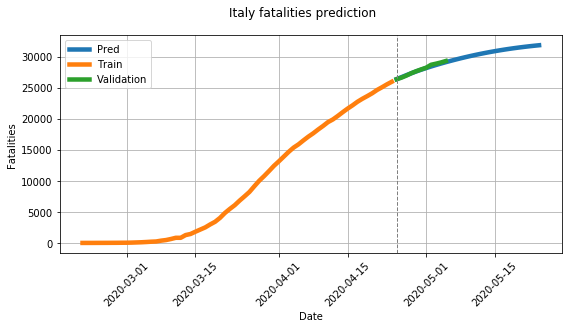

In [35]:
## deadModel.eval()

# get figure
fig, ax = plt.subplots(1, 1, figsize = (9, 4))
ax.tick_params(axis='x', rotation=45)
fig.suptitle(COUNTRY + ' fatalities prediction')

# make prediction
deadModel.returnFullSeq = False
pred   = deadModel(deadValData, future = 30).cpu().detach().numpy()
pred   = deadScaler.inverse_transform(pred[0])
error  = l1_norm_error(pred[:deadValLabel.shape[0]], deadValLabel.numpy())
print('MAPE: ', error)             

# plot prediction
predDate = pd.date_range(start = TRAIN_UP_TO, periods=pred.shape[0])              
sns.lineplot(y = pred, x = predDate, ax = ax, linewidth=4.5 )

# plot train data
showTrainData = deadData[deadData['Province_State'] == COUNTRY]
showTrainData = showTrainData[showTrainData['Date'] < TRAIN_UP_TO]
sns.lineplot(y = 'Fatalities', x = 'Date', data = showTrainData, ax = ax, linewidth=4.5)

# plot val data
showValData = deadData[deadData['Province_State'] == COUNTRY]
showValData = showValData[showValData['Date'] >= TRAIN_UP_TO]
sns.lineplot(y = 'Fatalities', x ='Date', data = showValData, ax = ax, linewidth=4.5);

ax.legend(['Pred', 'Train', 'Validation'])
ax.axvline(x=TRAIN_UP_TO, ymin = 0.0, ymax = 1.0, linestyle='--', lw = 1, color = '#808080')
ax.grid(True)